# Scikit-Learn Digits Dataset Analysis

## 1. 데이터 설명
이 노트북은 `sklearn.datasets.load_digits`를 사용하여 손글씨 숫자(0~9) 데이터를 분석합니다.
- **Feature**: 8x8 이미지의 픽셀 값 (64개 특성)
- **Target**: 0부터 9까지의 정수 (Label)
- **목표**: 데이터를 분석(EDA)하고, 전처리 후 여러 모델을 학습시켜 성능을 비교한 뒤, 
  상위 4개 모델로 앙상블 모델을 구축하고 하이퍼파라미터 튜닝을 통해 최적의 성능을 도출합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 시각화 설정
plt.style.use('seaborn-v0_8')
import warnings
warnings.filterwarnings('ignore')

## 2. 데이터 불러오기 및 확인

In [2]:
digits = load_digits()
X = digits.data
y = digits.target

print("데이터 크기 (Feature):", X.shape)
print("데이터 크기 (Target):", y.shape)
print("클래스 종류:", np.unique(y))

# 데이터프레임 변환 (확인용)
df = pd.DataFrame(X, columns=digits.feature_names)
df['target'] = y
df.head()

데이터 크기 (Feature): (1797, 64)
데이터 크기 (Target): (1797,)
클래스 종류: [0 1 2 3 4 5 6 7 8 9]


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


## 3. EDA (탐색적 데이터 분석) 및 시각화

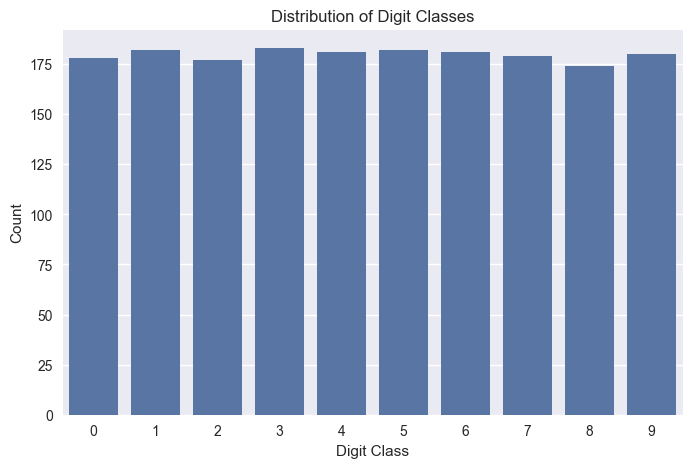

In [3]:
# 클래스 분포 확인
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=df)
plt.title('Distribution of Digit Classes')
plt.xlabel('Digit Class')
plt.ylabel('Count')
plt.show()

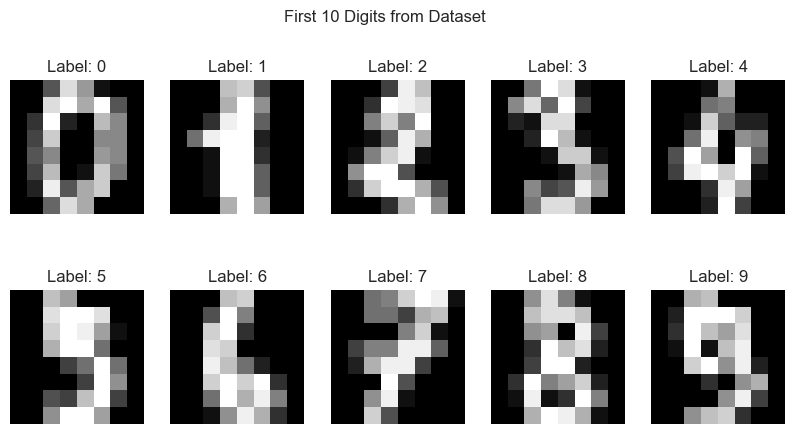

In [4]:
# 실제 이미지 시각화 (처음 10개)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f"Label: {digits.target[i]}")
    ax.axis('off')
plt.suptitle('First 10 Digits from Dataset')
plt.show()

## 4. 데이터 전처리 및 특성 엔지니어링
- **Scaling**: SVM, KNN 등 거리 기반 알고리즘을 위해 `StandardScaler` 적용
- **Split**: 학습용과 테스트용 데이터 분리

In [5]:
# 데이터 분리 (Train: 80%, Test: 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 스케일링 (Feature Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled Train Shape:", X_train_scaled.shape)
print("Scaled Test Shape:", X_test_scaled.shape)

Scaled Train Shape: (1437, 64)
Scaled Test Shape: (360, 64)


## 5. 모델링 (6가지 모델)
다음 6가지를 후보 모델로 선정하고 교차 검증 점수를 비교합니다.
1. Logistic Regression
2. SVC
3. Random Forest
4. KNN
5. Decision Tree
6. Gradient Boosting

In [6]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVC": SVC(probability=True, random_state=42),  # probability=True for Soft Voting
    "RandomForest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

model_scores = {}

print("Model Cross-Validation Scores (Accuracy):")
for name, model in models.items():
    # 5-Fold CV
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    mean_score = np.mean(scores)
    model_scores[name] = mean_score
    print(f"{name}: {mean_score:.4f}")

Model Cross-Validation Scores (Accuracy):
LogisticRegression: 0.9701
SVC: 0.9826
RandomForest: 0.9722
KNN: 0.9756
DecisionTree: 0.8497
GradientBoosting: 0.9624


## 6. 상위 4개 모델 선정

In [7]:
# 성능 기준으로 정렬하여 상위 4개 선택
sorted_models = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)
top_4_names = [item[0] for item in sorted_models[:4]]

print(f"Selected Top 4 Models: {top_4_names}")

best_estimators = [(name, models[name]) for name in top_4_names]

Selected Top 4 Models: ['SVC', 'KNN', 'RandomForest', 'LogisticRegression']


## 7. 앙상블 및 하이퍼파라미터 튜닝
- **앙상블**: `VotingClassifier` (Soft Voting)
- **튜닝**: `GridSearchCV`를 사용하여 앙상블 모델 내 일부 하이퍼파라미터 최적화 시도
  (예: SVC의 C값, RF의 n_estimators 등. 시간 관계상 대표적으로 SVC와 RF 파라미터 튜닝 예시 적용)

In [8]:
# 앙상블 모델 정의 (Soft Voting)
voting_clf = VotingClassifier(estimators=best_estimators, voting='soft')

# 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
# Top 4에 포함될 가능성이 높은 모델들의 파라미터 이름을 지정해야 함 (VotingClassifier는 '이름__파라미터' 형식)
# 여기서는 동적으로 Top 4가 바뀌더라도 에러가 나지 않도록, 
# 실제 선정된 모델 이름을 확인하여 그리드를 구성하는 것이 좋으나, 
# 편의상 자주 상위에 오르는 SVC와 RandomForest가 포함되었다고 가정하고 예시를 작성합니다.
# 만약 해당 모델이 Top 4에 없으면 튜닝에서 제외됩니다.

param_grid = {}

# SVC가 포함되어 있다면
if "SVC" in top_4_names:
    param_grid['SVC__C'] = [0.1, 1, 10]
    param_grid['SVC__kernel'] = ['rbf', 'linear']

# RandomForest가 포함되어 있다면
if "RandomForest" in top_4_names:
    param_grid['RandomForest__n_estimators'] = [50, 100, 200]

# KNN이 포함되어 있다면
if "KNN" in top_4_names:
    param_grid['KNN__n_neighbors'] = [3, 5, 7]

print("Tuning Hyperparameters:", param_grid.keys())

# GridSearchCV 실행
grid_search = GridSearchCV(voting_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

final_model = grid_search.best_estimator_

Tuning Hyperparameters: dict_keys(['SVC__C', 'SVC__kernel', 'RandomForest__n_estimators', 'KNN__n_neighbors'])
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'KNN__n_neighbors': 3, 'RandomForest__n_estimators': 100, 'SVC__C': 1, 'SVC__kernel': 'rbf'}
Best Cross-Validation Score: 0.9832985386221295


## 8. 최종 평가 (Evaluation)

Final Test Accuracy: 0.9889

Confusion Matrix:
[[36  0  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  1  0  0  0  0  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0]
 [ 0  0  0  0  0 37  0  0  0  0]
 [ 0  0  0  0  0  0 35  0  1  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  2  0  0  0  0  0  0 33  0]
 [ 0  0  0  0  0  0  0  0  0 36]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.95      0.97      0.96        36
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       0.97      1.00      0.99        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       1.00      1.00      1.00        36
           8       0.97      0.94      0.96        35
           9       1.00      1.00      1.00        36

  

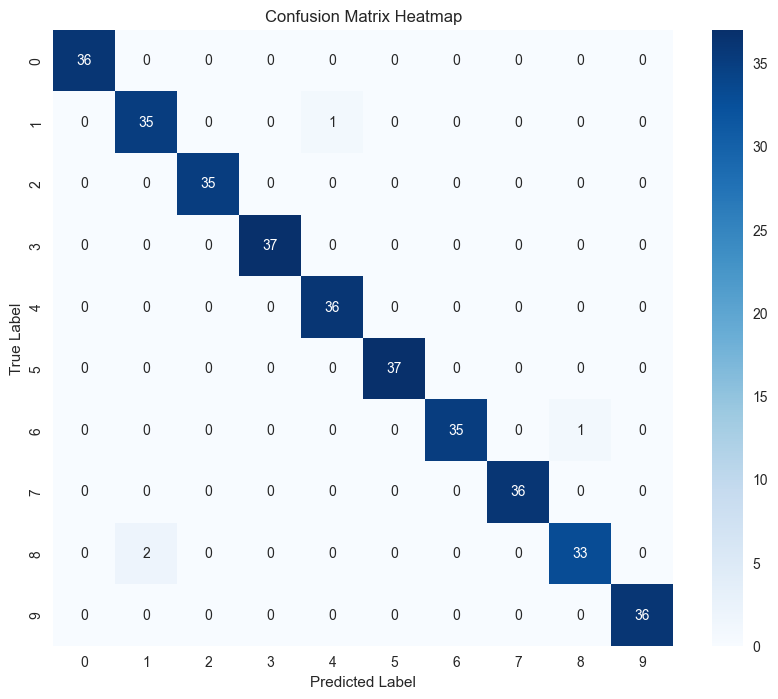

In [9]:
# 테스트 데이터로 최종 평가
y_pred = final_model.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Final Test Accuracy: {acc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Confusion Matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()